# Simulations

These simulations aim to demonstrate the usefulness and feasibility of the haplotype-segment matching procedure. 

1. [Basic application of method](#utility)

 - [Simulations on non-recombining locii](#utility-1)    
 - [Simulation on sequences with recombination](#utility-2)    
 
2. [Feasibility](#feasibility) 
3. [Testing OOA](#ooa) 

In [13]:
from __future__ import division
from __future__ import print_function

import msprime as msp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd
import itertools
import math

# sns.set_color_codes(palette='deep')
exp = np.exp
multinomial = scipy.stats.multinomial

## Basic application of method <a class="anchor" id="utility"></a>



### Simulations on non-recombining locii<a class="anchor" id="utility-1"></a>

In [2]:
def sim_basic_delay(Ne=1e4, delay=400, mu=1.2e-8, length=10000, reps=5000):
    """
    Simulation of three non-recombining sequences with one delayed sample
    """
    population_configurations = [msp.PopulationConfiguration(initial_size=Ne)]
    samples = [msp.Sample(0, 0), msp.Sample(0, 0), msp.Sample(0, delay)]
    
    return msp.simulate(
        population_configurations=population_configurations, 
        mutation_rate=mu,
        length=length,
        samples=samples,
        num_replicates = reps,
    )
        
def sim_basic_structure(Ne=0.5e4, 
                        join_1=240, join_2=100, merge=600, 
                        ancestry_1=0.6,
                        ancestry_2=None,
                        scale_1=1, scale_2=1,
                        mu=1.2e-8, r=None,
                        length=1000, reps=5000):
    """
    Simulation of three non-recombining sequences with population structure
    """
    if not ancestry_2:
        ancestry_2 = 1 - ancestry_1
    elif ancestry_1 + ancestry_2 > 1:
        raise Exception('Ancestry proportions exceed 1')


    population_configurations = [
        msp.PopulationConfiguration(initial_size=Ne),
        msp.PopulationConfiguration(initial_size=Ne/scale_1),
        msp.PopulationConfiguration(initial_size=Ne/scale_2)
    ]

    samples = [msp.Sample(0, 0), 
               msp.Sample(1, 0), 
               msp.Sample(2, 0),
    ]
    
    if join_2 < join_1:
        ancestry_1 = ancestry_2/(1 - ancestry_1)
        demographic_events = [
            # Modern sample joins ancient population 2 with probability ancestry_2 at time join_2_time
            msp.MassMigration(time=join_2, source=0, destination=2, proportion=ancestry_2),
            
            # Modern sample joins ancient population 1, with adjusted ancestry_1, at time join_1_time
            msp.MassMigration(time=join_1, source=0, destination=1, proportion=ancestry_1),
    
            # Populations merges into 0
            msp.MassMigration(time=merge, source=1, destination=0, proportion=1),
            msp.MassMigration(time=merge, source=2, destination=0, proportion=1),
        ]
        
    else:
        ancestry_2 = ancestry_1/(1 - ancestry_2)
        demographic_events = [
            # Modern sample joins ancient population 1 with probability ancestry_1 at time join_1_time
            msp.MassMigration(time=join_1, source=0, destination=1, proportion=ancestry_1),
            
            # Modern sample joins ancient population 2, with adjusted ancestry_2, at time join_2_time
            msp.MassMigration(time=join_2, source=0, destination=2, proportion=ancestry_2),
    
            # Populations merges into 0
            msp.MassMigration(time=merge, source=1, destination=0, proportion=1),
            msp.MassMigration(time=merge, source=2, destination=0, proportion=1),
        ]

    return msp.simulate(
        population_configurations=population_configurations, 
        mutation_rate=mu,
        length=length,
        samples=samples,
        num_replicates=reps,
        demographic_events = demographic_events
    )


def sim_recom_structure(Ne=1e4, 
                        join_1=240, 
                        join_2=100, 
                        merge=600, 
                        ancestry_1=0.6,
                        ancestry_2=None,
                        scale_1=2, 
                        scale_2=2,
                        mu=1.2e-8,
                        r=1e-8,
                        length=10e6,
                        reps=None):
    """
    Simulation of three recombining sequences with population structure
    """
    if not ancestry_2:
        ancestry_2 = 1 - ancestry_1
    elif ancestry_1 + ancestry_2 > 1:
        raise Exception('Ancestry proportions exceed 1')


    population_configurations = [
        msp.PopulationConfiguration(initial_size=Ne),
        msp.PopulationConfiguration(initial_size=Ne/scale_1),
        msp.PopulationConfiguration(initial_size=Ne/scale_2)
    ]

    samples = [msp.Sample(0, 0), 
               msp.Sample(1, 0), 
               msp.Sample(2, 0),
    ]
    
    if join_2 < join_1:
        ancestry_1 = ancestry_2/(1 - ancestry_1)
        demographic_events = [
            # Modern sample joins ancient population 2 with probability ancestry_2 at time join_2_time
            msp.MassMigration(time=join_2, source=0, destination=2, proportion=ancestry_2),
            
            # Modern sample joins ancient population 1, with adjusted ancestry_1, at time join_1_time
            msp.MassMigration(time=join_1, source=0, destination=1, proportion=ancestry_1),
    
            # Populations merges into 0
            msp.MassMigration(time=merge, source=1, destination=0, proportion=1),
            msp.MassMigration(time=merge, source=2, destination=0, proportion=1),
        ]
        
    else:
        ancestry_2 = ancestry_1/(1 - ancestry_2)
        demographic_events = [
            # Modern sample joins ancient population 1 with probability ancestry_1 at time join_1_time
            msp.MassMigration(time=join_1, source=0, destination=1, proportion=ancestry_1),
            
            # Modern sample joins ancient population 2, with adjusted ancestry_2, at time join_2_time
            msp.MassMigration(time=join_2, source=0, destination=2, proportion=ancestry_2),
    
            # Populations merges into 0
            msp.MassMigration(time=merge, source=1, destination=0, proportion=1),
            msp.MassMigration(time=merge, source=2, destination=0, proportion=1),
        ]

    return msp.simulate(
        population_configurations=population_configurations, 
        mutation_rate=mu,
        length=length,
        samples=samples,
        num_replicates=reps,
        demographic_events = demographic_events,
        recombination_rate = r,
    )

Calculating matches of population 1 and population 2

In [3]:
args = {'Ne':1e4, 
        'join_1':240, 
        'join_2':100,
        'merge':600, 
        'ancestry_1':0.5,
        'ancestry_2':0.5,
        'scale_1':2, 
        'scale_2':2,
        'reps':1000,
        'mu': 1.2e-8,
        'length':1000}

def compare_theoretical_pop_matches(args):
    lmb1, lmb2 = 1/args['scale_1'], 1/args['scale_2']
    t1, t2 = (args['merge'] - args['join_1'])/(2*args['Ne']), (args['merge'] - args['join_2'])/(2*args['Ne'])
    
    if t1<0 or t2<0:
        raise Exception('Invalid join times: {}, {}'.format(t1,t2))
    
    p1 = args['ancestry_1']
    if 'ancestry_2' in args:
        p2 = args['ancestry_2']
        if p1 + p2 > 1:
            raise Exception('Ancestry proportions exceed 1')
        p0 = 1 - p1 - p2
    else:
        p2 = 1 - p1
        p0 = 0
    
    theta = 4*args['Ne']*args['mu']*args['length']
    B = (p0 + p1*exp(-t1/lmb1) + p2*exp(-t2/lmb2))
    d2 = 1 + theta/2
    
    A = {1:p1*exp(-t1/lmb1)/(lmb1 + 1),
         2:p2*exp(-t2/lmb2)/(lmb2 + 1)}
    d1 = {1: 1/lmb1 - theta/2,
          2: 1/lmb2 - theta/2}   
    t = {1: t1,
         2: t2}
    I0 = {1: p2*(1 - exp(-t2/lmb2)) + (2/3)*B,
          2: p1*(1 - exp(-t1/lmb1)) + (2/3)*B}
    lmb = {1:lmb1,
           2:lmb2}
    
    out = []
    for i in 1,2:
        I = I0[i]
        I += A[i]*(exp(d1[i]*t[i])-1)/d1[i] + A[i]*(exp(-d2*t[i])-1)/d2
        I += A[i]*(exp((1 + 1/lmb[i])*t[i])-1)*(exp(-(1 + theta/2)*t[i]))/d2
        I += B/(3*d2)
        out.append(1-I)
    return out[0], out[1], (out[0]-out[1])/(out[0] + out[1]), out[0]/(out[0] + out[1])

print(compare_theoretical_pop_matches(args))

(0.06525509329308554, 0.0665813510711426, -0.010059872173076604, 0.4949700639134617)


(202, 783, 0.2050761421319797)
theoretical expected values: 231.8116025180379 247.64086923063132


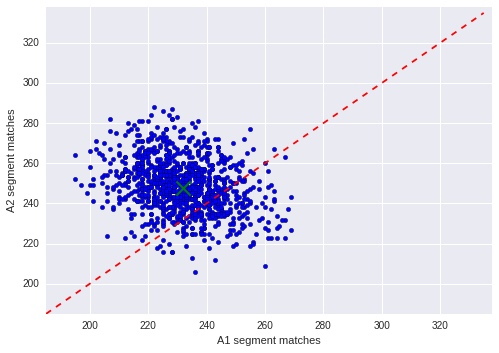

In [4]:
#240gens = +/- 6000ya
#100gens = +/- 2500ya
#600gens = +/- 15000ya

args = {'Ne':1e4,
        'join_1':240, 
        'join_2':100, 
        'merge':600,  
        'ancestry_1':0.4,
        'scale_1':1, 
        'scale_2':2,
        'reps':1000,
        'mu': 1.2e-8,
        'r':None,
        'length':10000}

def compare_simulated_pop_matches(simulation=sim_basic_structure, reps=10, args=args):
    plt.clf()
    A1, A2 = [], []
    
    for _ in range(reps):
        a1, a2 = 0, 0
        for s in simulation(**args):
            tree = s.trees().next()
            p = tree.get_parent(0)
            if tree.get_parent(1) == p:
                muts = []
                for m in tree.mutations():
                    if m.node == p:
                        muts.append(m)
                if muts:
                    a1 += 1
            elif tree.get_parent(2) == p:
                muts = []
                for m in tree.mutations():
                    if m.node == p:
                        muts.append(m)
                if muts:
                    a2 += 1
            
        A1.append(a1)
        A2.append(a2)
    
    plt.scatter(A1, A2)
    one,two,r_one, r_two = compare_theoretical_pop_matches(args)
    plt.scatter([one*args['reps']],[two*args['reps']], color='g', marker="x", s=200, linewidth=2.0)
    
    test1 = sum([1 if t>0 else 0 for t in [i - j for i,j in zip(A1,A2)]])
    test2 = sum([1 if t>0 else 0 for t in [j - i for i,j in zip(A1,A2)]])
    lower = min(A1 + A2) - 10
    upper = max(A1 + A2) + 50
    
    x = np.arange(lower, upper, 10)
    y = x    
    plt.plot(x,y, '--', color='red')
    plt.xlabel('A1 segment matches')
    plt.ylabel('A2 segment matches')
    plt.xlim(lower, upper)
    plt.ylim(lower, upper)
    
#     plt.show()
    
    return test1, test2, test1/(test1+test2)

one,two, r_one, r_two = compare_theoretical_pop_matches(args)
print(compare_simulated_pop_matches(args=args, reps=1000))
print('theoretical expected values:', one*args['reps'], two*args['reps'])

plt.show()

(0.18030155028322137, 0.18486736202534293, -0.012503287076813082, 0.4937483564615935)
0
100
200
300
400
mean 0.4979628243433935


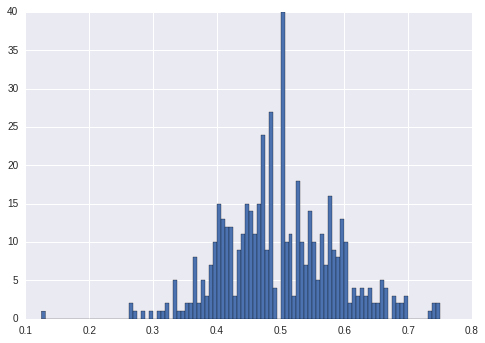

In [5]:
# Testing statistics
ARGS = {'Ne':1e4, 
        'join_1':240, 
        'join_2':100,
        'merge':240, 
        'ancestry_1':0.4,
        'ancestry_2':0.6,
        'scale_1':2, 
        'scale_2':2,
        'reps':1000,
        'mu': 1.2e-8,
        'r':None,
        'length':5000}

-

In [6]:
def ratios(a,b):
    return (a-b)/(a+b), (a)/(a+b)

ratios(1405,1390)

(0.005366726296958855, 0.5026833631484794)

In [7]:
#Recombining locii
ARGS = {'Ne':1e4, 
        'join_1':240, 
        'join_2':100,
        'merge':600, 
        'ancestry_1':0.4,
        'ancestry_2':0.6,
        'scale_1':2, 
        'scale_2':2,
        'mu': 1.2e-8,
        'r': 1.0e-8,
        'length':40e6}

def compare_simulated_sequence(simulation=sim_recom_structure, args=ARGS):
    sim = simulation(**args)
#     print('Number of trees:', sim.get_num_trees())
        
    tree_lengths = []
    a1, a2 = 0, 0
    for tree in sim.trees():
        l = tree.get_interval()[1] - tree.get_interval()[0]
        tree_lengths.append(l)
        p = tree.get_parent(0)
        if tree.get_parent(1) == p:
            muts = []
            for m in tree.mutations():
                if m.node == p:
                    muts.append(m)
            if muts:
                a1 += 1
        elif tree.get_parent(2) == p:
            muts = []
            for m in tree.mutations():
                if m.node == p:
                    muts.append(m)
            if muts:
                a2 += 1
    
#     print('Mean tree length:', np.mean(tree_lengths))
    
    return sim.get_num_trees(), np.mean(tree_lengths), a1, a2, (a1-a2)/(a1+a2), a1/(a1+a2)

out = compare_simulated_sequence()

args = ARGS.copy()
args['length'] = round(out[1],1)
comparison = compare_simulated_trees(args=args, reps=out[0])
theory = compare_theoretical_pop_matches(args=args)

print(out, comparison, theory, sep='\n')

(17627, 2269.2460430022124, 1873, 2219, -0.08455522971652003, 0.45772238514173996)
(2081, 2180, -0.0232339826331847, 0.48838300868340767)
(0.1174593116224788, 0.12287432695087563, -0.02253124182091583, 0.4887343790895421)


0
10
20


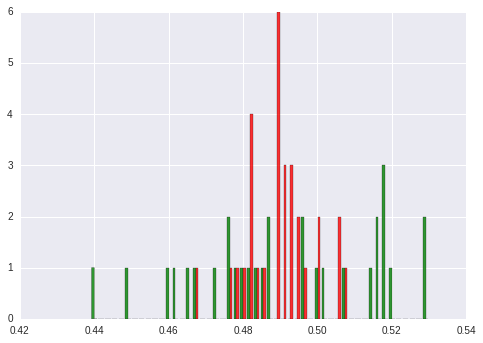

0.49121755579819226 17233.333333333332 2321.499825216759
(0.11919783616580681, 0.12469298940040319, -0.02253120108900768, 0.4887343994554962)


In [8]:
NUM = 30
ARGS = {'Ne':1e4, 
        'join_1':240, 
        'join_2':100,
        'merge':600, 
        'ancestry_1':0.4,
        'ancestry_2':0.6,
        'scale_1':2, 
        'scale_2':2,
        'mu': 1.2e-8,
        'r': 1.0e-8,
        'length':40e6}

seq_data = []
tree_data = []
seq_num_trees = []
seq_tree_length = []

for i in range(NUM):
    out = compare_simulated_sequence(args=ARGS)
    seq_data.append(out[-1])
    seq_num_trees.append(out[0])
    seq_tree_length.append(out[1])
    args = ARGS.copy()
    args['length'] = round(out[1],1)
    comparison = compare_simulated_trees(args=args, reps=out[0])
    tree_data.append(comparison[-1])
    if i%10 == 0:
        print(i)

# plt.hist(seq_data)
plt.hist([seq_data,tree_data], color=['g','r'], alpha=0.8, bins=50)
plt.show()

print(np.mean(seq_data), np.mean(seq_num_trees), np.mean(seq_tree_length))
ARGS['length'] = np.mean(seq_tree_length)
print(compare_theoretical_pop_matches(args=ARGS))

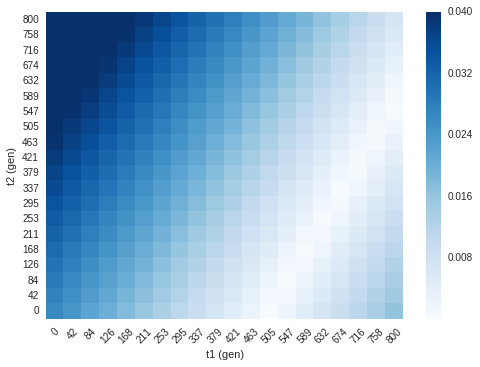

In [9]:
DMNS = 1 # Dimensions = DMNSxDMNS
# fig, axes = plt.subplots(DMNS, DMNS, figsize=(DMNS**2, DMNS**2), sharex=True, sharey=True)
sns.set()
VMIN = -0.2
VMAX = 0.2
BLOCKS = 20
OBSERVED = np.mean([0.53, 0.49, 0.508, 0.513, 0.48, 0.516, 0.519, 0.5])
MERGE_TIME=800
ARGS = {'Ne':1e4, 
        'join_1':0, 
        'join_2':0,
        'merge':MERGE_TIME, 
        'ancestry_1':0.4,
        'ancestry_2':0.6,
        'scale_1':2, 
        'scale_2':2.5,
        'reps':10000,
        'mu': 1.2e-8,
        'length':5000}

def heatmap_single():
   
    vals = np.linspace(0, MERGE_TIME, num=BLOCKS)
    round_vals = map(lambda x: int(round(x)), vals)
       
    d = np.zeros((BLOCKS,BLOCKS))

    for row, t1 in enumerate(vals):
        ARGS['join_1'] = t1
        out = []
        for t2 in vals:
            ARGS['join_2'] = t2
            tmp = compare_theoretical_pop_matches(args=ARGS)[3]
            tmp = abs(OBSERVED-tmp)
            out.append(tmp)

        d[row:] = out

    d = pd.DataFrame(d, index=round_vals, columns=round_vals)

    axes = sns.heatmap(d, cmap='Blues', vmax=0.04)
    axes.set_xlabel("t1 (gen)")
    axes.set_ylabel("t2 (gen)")
    axes.invert_yaxis()
    axes.set_xticklabels(axes.get_xticklabels(),rotation=45)

heatmap_single()
plt.show()

(17557, 2278.2935581249644, 2006, 2005, 0.0002493143854400399, 0.50012465719272)
Check normed: 1.000008582001543


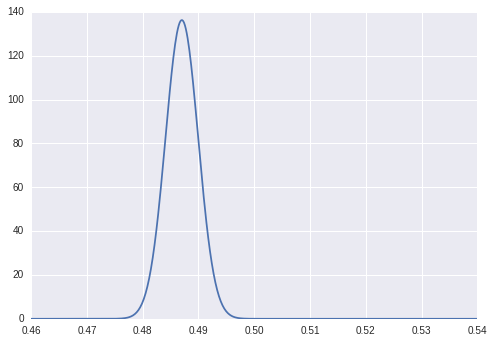

0.48709418837675356
{'join_2': 150, 'join_1': 250, 'reps': 10000, 'Ne': 10000.0, 'ancestry_1': 0.1, 'ancestry_2': 0.9, 'scale_1': 2, 'length': 5000, 'mu': 1.2e-08, 'merge': 300, 'scale_2': 2, 'r': None}


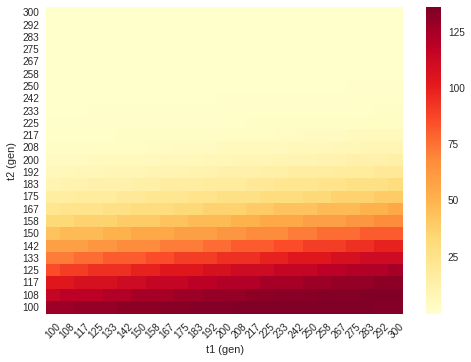

In [10]:
def log_stirling_choose(n,k):
    t1 = np.log(np.sqrt(n/(2*math.pi*k*(n-k))))
    t2 = n*np.log(n) - k*np.log(k) - (n-k)*np.log(n-k)
    return t1 + t2

BLOCKS=25
MERGE_TIME=300
ARGS = {'Ne':1e4, 
        'join_1':250, 
        'join_2':150,
        'merge':MERGE_TIME, 
        'ancestry_1':0.1,
        'ancestry_2':0.9,
        'scale_1':2, 
        'scale_2':2,
        'reps':10000,
        'mu': 1.2e-8,
        'r':None,
        'length':5000}

APPROX_OBSERVED = [[1325,1175], [1220,1270], [1320, 1280], [1340,1270], 
                   [1380,1490], [1460,1370], [1480,1370], [1405,1390]]

def prior(p):
    return p

def posterior(p,obs):
    num = 0
    for o in obs:
        num += o[0]*np.log(p) + o[1]*np.log(1-p)
    
    x = 1 + sum([o[0] for o in obs])
    y = 1 + sum([o[1] for o in obs])
    
    beta = np.log(np.sqrt(2*math.pi)) + (x - 0.5)*np.log(x) + (y-0.5)*np.log(y) - (x + y-0.5)*np.log(x+y)
    
    p = prior(p)
    
    return np.exp(num - beta)
    

obs = []
for i in range(8):
    obs.append(compare_simulated_trees(args=ARGS)[0:2])
print(out)

START = 0.46
END = 0.54
INTS = 500
p_vals = np.linspace(START,END,INTS)

# y = posterior(p_vals, APPROX_OBSERVED) # could integrate to get eg. prob > 0.5 
y = posterior(p_vals, obs)
print('Check normed:', scipy.integrate.simps(y, dx=p_vals[1]-p_vals[0]))
plt.plot(p_vals,y)
plt.show()
y = list(y)
print(p_vals[y.index(max(y))])
# print(compare_theoretical_pop_matches(args=ARGS)[-1])

def interpolate(val,p,y):
    if val in p:
        return y[p.index(i)]
    
    for i,j in enumerate(p):
        if j<val:
            continue
        break
    
    up = y[i]
    low = y[i-1]
    
#     print(val, up, low, p[i], p[i-1])
    
    return (up-low)*(val - p[i-1])*(j-p[i-1]) + low
    

def heatmap_probs(p,y,args=ARGS):
   
    vals1 = np.linspace(100, MERGE_TIME, num=BLOCKS)
    vals2 = np.linspace(100, MERGE_TIME, num=BLOCKS)
    round_vals1 = map(lambda x: int(round(x)), vals1)
    round_vals2 = map(lambda x: int(round(x)), vals2)
       
    d = np.zeros((BLOCKS,BLOCKS))

    for row, t2 in enumerate(vals2):
        args['join_2'] = t2
        out = []
        for t1 in vals1:
            args['join_1'] = t1
            tmp = compare_theoretical_pop_matches(args=ARGS)[3]
            out.append(interpolate(tmp,p,y))
#             out.append(tmp)
        d[row:] = out

    d = pd.DataFrame(d, index=round_vals1, columns=round_vals2)

    axes = sns.heatmap(d, cmap='YlOrRd')
    axes.set_xlabel("t1 (gen)")
    axes.set_ylabel("t2 (gen)")
    axes.invert_yaxis()
    axes.set_xticklabels(axes.get_xticklabels(),rotation=45)

print(ARGS)
heatmap_probs(p_vals,y, args=ARGS)
plt.show()




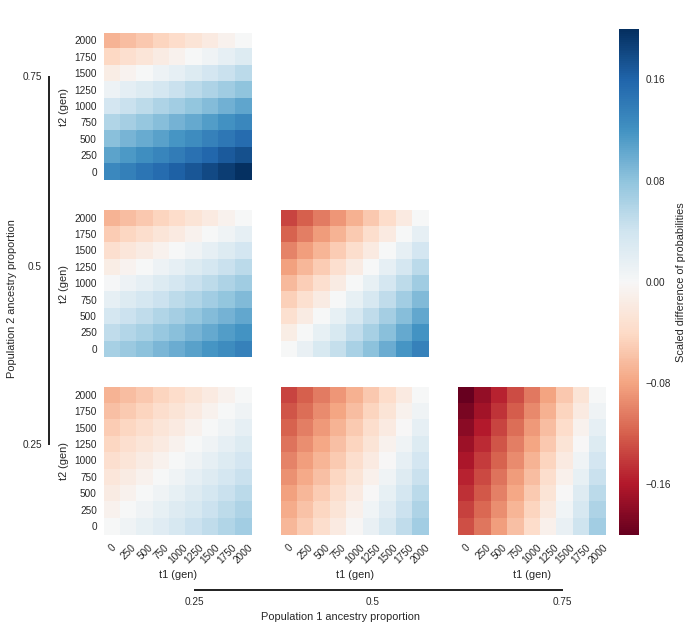

In [11]:
DMNS = 3 # Dimensions = DMNSxDMNS
fig, axes = plt.subplots(DMNS, DMNS, figsize=(DMNS**2, DMNS**2), sharex=True, sharey=True)
sns.set()
VMIN = -0.2
VMAX = 0.2
BLOCKS = 9

MASK = [(0,1), (0,2), (1,2)]
for r,c in MASK:
    axes[r,c].axis('off')

MERGE_TIME = 2000
ARGS = {'Ne':1e4, 
        'join_1':1000, 
        'join_2':500,
        'merge':MERGE_TIME, 
        'ancestry_1':0.5,
        'ancestry_2':0.5,
        'scale_1':2, 
        'scale_2':2,
        'reps':10000,
        'mu': 1.2e-8,
        'length':5000}


def heatmap_times(axes):
    dct1 = {0:0.75,
           1:0.5,
           2:0.25}
    dct2 = {2:0.75,
           1:0.5,
           0:0.25}
    
    vals = np.linspace(0, MERGE_TIME, num=BLOCKS)
    round_vals = map(lambda x: int(round(x)), vals)
    
    for p in itertools.product([0,1,2],repeat=2):
        if p in MASK:
            continue
        p1, p2 = dct1[p[0]], dct2[p[1]]
        
        args = ARGS.copy()
        args['ancestry_1'] = p1
        args['ancestry_2'] = p2
        
        d = np.zeros((BLOCKS,BLOCKS))
        
        for row, t1 in enumerate(vals):
            args['join_1'] = t1
            out = []
            for t2 in vals:
                args['join_2'] = t2
                tmp = compare_theoretical_pop_matches(args)
                out.append((tmp[0] - tmp[1])/(tmp[0] + tmp[1]))
            
            d[row:] = out
        
        d = pd.DataFrame(d, index=round_vals, columns=round_vals)
        
        sns.heatmap(d, ax=axes[p[0],p[1]], cmap='RdBu', vmin=VMIN, vmax=VMAX, 
                    cbar=False)
        
        if p[0] == 2:
            axes[p[0],p[1]].set_xlabel("t1 (gen)")
        if p[1] == 0:
            axes[p[0],p[1]].set_ylabel("t2 (gen)")
        axes[p[0],p[1]].invert_yaxis()
        axes[p[0],p[1]].zorder=1
        axes[p[0],p[1]].set_xticklabels(axes[p[0],p[1]].get_xticklabels(),rotation=45)
    
    with sns.axes_style('white', {'axes.linewidth':2}):
        frame = fig.add_axes([0.04, 0.04, 0.9, 0.9],
                     xticklabels=[0.25,0.50,0.75], yticklabels=[0.25,0.50,0.75],
                     xlim=(0,1), ylim=(0,1))
        frame.set_xticks([0.25,0.555,0.88])
        frame.set_yticks([0.25,0.555,0.88])
        frame.set_xlabel('Population 1 ancestry proportion')
        frame.set_ylabel('Population 2 ancestry proportion')
        frame.zorder=0
        sns.despine(ax=frame, trim=True)

    with sns.axes_style('white'):
        color_bar = fig.add_axes([0.92, 0.125, 0.03, 0.78], xticklabels=[], yticklabels=[])
        sns.heatmap([(0,)],xticklabels=False, yticklabels=False, 
                    cmap='RdBu', vmin=VMIN, vmax=VMAX, cbar_ax=color_bar, cbar_kws={'label': 'Scaled difference of probabilities'})
    
#     plt.savefig('fig_theory_anc_props.eps', format='eps', dpi=1200, bbox_inches='tight')
    plt.show()

heatmap_times(axes)



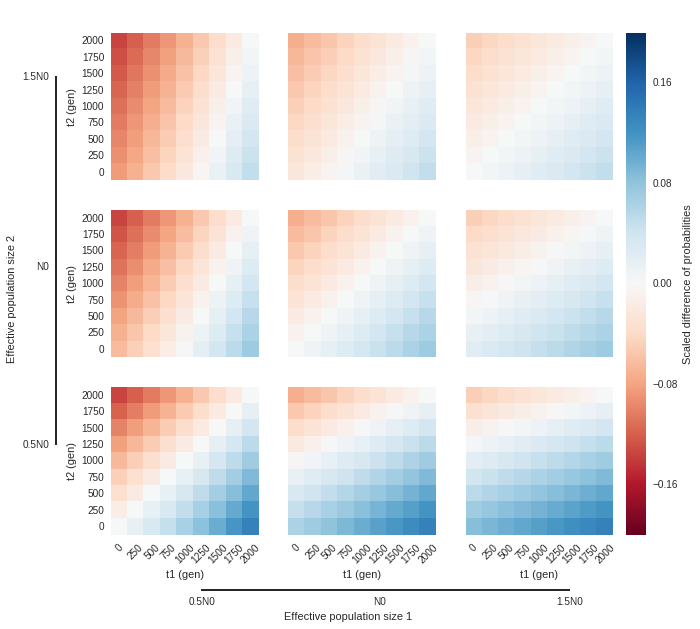

In [12]:
DMNS = 3 # Dimensions = DMNSxDMNS
fig, axes = plt.subplots(DMNS, DMNS, figsize=(DMNS**2, DMNS**2), sharex=True, sharey=True)
sns.set()
VMIN = -0.2
VMAX = 0.2
BLOCKS = 9

MERGE_TIME = 2000
ARGS = {'Ne':1e4, 
        'join_1':500, 
        'join_2':500,
        'merge':MERGE_TIME, 
        'ancestry_1':0.5,
        'ancestry_2':0.5,
        'scale_1':2, 
        'scale_2':2,
        'reps':10000,
        'mu': 1.2e-8,
        'length':5000}


def heatmap_Ne(axes):
    dct1 = {0:2/3,
           1:1,
           2:2,}
    dct2 = {2:2/3,
           1:1,
           0:2}
    
    vals = np.linspace(0, MERGE_TIME, num=BLOCKS)
    round_vals = map(lambda x: int(round(x)), vals)
    
    for p in itertools.product([0,1,2],repeat=2):
        p_1, p_2 = dct1[p[0]], dct2[p[1]]
        
        args = ARGS.copy()
        args['scale_1'] = p_1
        args['scale_2'] = p_2
        
        d = np.zeros((BLOCKS,BLOCKS))
        
        for row, t1 in enumerate(vals):
            args['join_1'] = t1
            out = []
            for t2 in vals:
                args['join_2'] = t2
                tmp = compare_theoretical_pop_matches(args)
                out.append((tmp[0] - tmp[1])/(tmp[0] + tmp[1]))
            
            d[row:] = out
        
        d = pd.DataFrame(d, index=round_vals, columns=round_vals)
        
        sns.heatmap(d, ax=axes[p[0],p[1]], cmap='RdBu', vmin=VMIN, vmax=VMAX, 
                    cbar=False)
        
        if p[0] == 2:
            axes[p[0],p[1]].set_xlabel("t1 (gen)")
        if p[1] == 0:
            axes[p[0],p[1]].set_ylabel("t2 (gen)")
        axes[p[0],p[1]].invert_yaxis()
        axes[p[0],p[1]].zorder=1
        axes[p[0],p[1]].set_xticklabels(axes[p[0],p[1]].get_xticklabels(),rotation=45)
    
    with sns.axes_style('white', {'axes.linewidth':2}):
        frame = fig.add_axes([0.04, 0.04, 0.9, 0.9],
                     xticklabels=['0.5N0','N0','1.5N0'], yticklabels=['0.5N0','N0','1.5N0'],
                     xlim=(0,1), ylim=(0,1))
        frame.set_xticks([0.25,0.555,0.88])
        frame.set_yticks([0.25,0.555,0.88])
        frame.set_xlabel('Effective population size 1')
        frame.set_ylabel('Effective population size 2')
        frame.zorder=0
        sns.despine(ax=frame, trim=True)

    with sns.axes_style('white'):
        color_bar = fig.add_axes([0.92, 0.125, 0.03, 0.775], xticklabels=[], yticklabels=[])
        sns.heatmap([(0,)],xticklabels=False, yticklabels=False, 
                    cmap='RdBu', vmin=VMIN, vmax=VMAX, cbar_ax=color_bar, cbar_kws={'label': 'Scaled difference of probabilities'})
    
#     plt.savefig('fig_theory_anc_Ne.eps', format='eps', dpi=1200, bbox_inches='tight')
    plt.show()

heatmap_Ne(axes)